In [68]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.models import load_model

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

# Set the default font family to Times New Roman, default tick label color to black, and default line plot style
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["xtick.color"] = "black"
plt.rcParams["ytick.color"] = "black"
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors) + plt.cycler("marker", ["o", "s", "D", "v", "X", "P", ">", "<", "H", "d"])  # Set the default line plot style



# Function to create RNN dataset
def create_rnn_dataset(X_norm, y_scaled, lookback):
    X, y = [], []
    for i in range(len(X_norm)-lookback):
        X.append(X_norm[i:(i+lookback)])
        y.append(y_scaled[(i+lookback)])
    return np.array(X), np.array(y)


# Define a function to calculate performance metrics
def calculate_performance(observed, predicted):
    mse = mean_squared_error(observed, predicted)
    mae = mean_absolute_error(observed, predicted)
    rmse = math.sqrt(mse)
    r2 = r2_score(observed, predicted)
    
    # Return a dictionary with the metrics
    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }


In [69]:
# Set up GPU configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print('GPU is being used')
    except RuntimeError as e:
        print(e)

GPU is being used


In [70]:
data_true = pd.read_csv(r"G:\My Drive\Google Drive - VirginiaTech\OneDrive - Virginia Tech\01_Terms\02_Fall_2024\Projects\DownloadedData\NOAA\ModelMergedData\KK_ML_Project_UTF-8 _All_Variables.csv")
print(data_true.dtypes)
#drop the date column, all data are at 1hr interval. Timestamp has no additional values
data = data_true.drop(columns=['DateTime (GMT)']) 

DateTime (GMT)       object
HT (m)              float64
NTR (m)             float64
MSL (Pa)            float64
SST (°C)            float64
Air_Temp (°C)       float64
Wind Speed (m/s)    float64
TWL (m)             float64
dtype: object


In [71]:
# Load Fortmyers latest.csv dataset
X = data.iloc[:,:-1]  # All columns excepect the last column (target variable)
y = data.iloc[:, -1]  # The target variable

# Step 1: Normalize the data using MinMaxScaler
# Note: HT (m), NTR (m) can be scaled from -1 to 1 as the magnitude both has negative and positive values
# Simialarly Wind Speed (m/s) and Wind Gist (m/s) has been scaled from 0 to 1 because there are no negative values here.
# Likewise, the target varibale has been scaled from -1 to 1.
######################### HOWEVER #######################################
# As scaling HT and NTR from -1 to 1 preserves their positive and negative values, while Wind Speed and Wind Gust are appropriately scaled
# from 0 to 1 due to their non-negative nature. Similarly, scaling the target variable from -1 to 1 is beneficial if it has both positive
# a nd negative values. However, using different scaling ranges for features may cause some models, like neural networks, to focus
# disproportionately on certain variables, potentially slowing convergence. To mitigate this, consider experimenting with
# uniform scaling across all features for better consistency, especially in models that are sensitive to feature magnitudes.

########################## Therefore, as a start, all input varibales are scaled from -1 to 1 and all target varibales are scaled from -1 to 1.
########################## A future trail will be held to see if HT (m), NTR (m) can be scaled from 0 to 1, 
########################### and Wind Speed (m/s) and Wind Gist (m/s) scaled from 0 to 1 can help to improve the model.
########################### so as a start all input variables are scaled from -1 to 1. Including the windspeed and wind gust.

##### Therefore, speperate scaling algorithms are set for input and target varibales

# Step 1: Initialize MinMaxScaler for X (features) and set range to (-1, 1) 
# this can be later changed into 0 to 1
scaler_X = MinMaxScaler(feature_range=(-1, 1))
# scaler_X = MinMaxScaler(feature_range=(0, 1))
X_norm = scaler_X.fit_transform(X)

# Initialize MinMaxScaler for y (target) and set range to (-1, 1)
scaler_y = MinMaxScaler(feature_range=(-1, 1))

# Reshape y to a 2D array since MinMaxScaler expects a 2D input
y_reshaped = y.values.reshape(-1, 1)

# Fit and transform the target variable (y) to scale it between -1 and 1
y_scaled = scaler_y.fit_transform(y_reshaped)

# Inverse transform the scaled target variable back to the original scale
# This is done so that we can calcualte performance metrics
y_original = scaler_y.inverse_transform(y_scaled)



In [72]:
# Check for NaN values in scaled data
print("Check for NaN in X_norm after scaling:", np.isnan(X_norm).sum())
print("Check for NaN in y_scaled after scaling:", np.isnan(y_scaled).sum())
print("-----------------------------------------------------------")

# Print the minimum and maximum values of the scaled data
min_value_X = np.min(X_norm)
max_value_X = np.max(X_norm)
print("Minimum value of scaled data (X):", min_value_X)
print("Maximum value of scaled data (X):", max_value_X)
print("-----------------------------------------------------------")
min_value_y = np.min(y_scaled)
max_value_y = np.max(y_scaled)
print("Minimum value of scaled data (y):", min_value_y)
print("Maximum value of scaled data (y):", max_value_y)

Check for NaN in X_norm after scaling: 0
Check for NaN in y_scaled after scaling: 0
-----------------------------------------------------------
Minimum value of scaled data (X): -1.0
Maximum value of scaled data (X): 1.0000000000000004
-----------------------------------------------------------
Minimum value of scaled data (y): -1.0
Maximum value of scaled data (y): 0.9999999999999999


In [73]:
print(X_norm.shape)
print(y_scaled.shape)

(61369, 6)
(61369, 1)


In [74]:
#Training data 
data_spilt=0.80
train_size = int(0.80 * len(X_norm))
print('Data Split(%): ', data_spilt*100)
print('---------------------------------')
# Split the preprocessed dataset into training and testing sets
X_train = X_norm[:train_size]
X_test = X_norm[train_size:]
y_train = y_scaled[:train_size]
y_test = y_scaled[train_size:]

# lookback samples. Initially starting at 4 hours, 1/3 of one single tide cycle. Will be updated later 3,4,5,6 .
lookback= 12

# Define the number of input features
num_input_features = X_norm.shape[1]

# Define the number of output fea.shape[1]tures
num_output_features = y_scaled.shape[1]

# Split the preprocessed dataset into training and testing sets
X_train, X_test = X_norm[:train_size], X_norm[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

print("Number of samples in X_train:", X_train.shape[0])
print("Number of samples in X_test:", X_test.shape[0])
print("Number of samples in y_train:", y_train.shape[0])
print("Number of samples in y_test:", y_test.shape[0])


Data Split(%):  80.0
---------------------------------
Number of samples in X_train: 49095
Number of samples in X_test: 12274
Number of samples in y_train: 49095
Number of samples in y_test: 12274


In [75]:
### creating the rnn data set for timeseiries with lookback
X_train_rnn, y_train_rnn = create_rnn_dataset(X_train, y_train, lookback)
X_test_rnn, y_test_rnn = create_rnn_dataset(X_test, y_test, lookback)

print("Expected input data shape for test: (batch_size, timesteps, num_features)")
print("Shape of X_train_rnn:", X_train_rnn.shape)
print("There will be a total of 49089 samples. The first sample will be as following: ")

Expected input data shape for test: (batch_size, timesteps, num_features)
Shape of X_train_rnn: (49083, 12, 6)
There will be a total of 49089 samples. The first sample will be as following: 


Sample 1:

```python
[
    [HT_t1, NTR_t1, WindSpeed_t1, WindGust_t1],
    [HT_t2, NTR_t2, WindSpeed_t2, WindGust_t2],
    [HT_t3, NTR_t3, WindSpeed_t3, WindGust_t3],
    [HT_t4, NTR_t4, WindSpeed_t4, WindGust_t4],
    [HT_t5, NTR_t5, WindSpeed_t5, WindGust_t5],
    [HT_t6, NTR_t6, WindSpeed_t6, WindGust_t6],
]

Shape of X_train_rnn: (49089, 6, 4)
Samples: The model will process each of the 49,089 sequences individually to learn patterns from the historical data.
Timesteps: The model considers the past 6 time steps (lookback) for each sequence, learning how these past observations influence the next time step.
Features: The 4 features for each time step provide the model with a comprehensive view of the conditions at each point in time.


In [76]:
### Not understanding why you have to transpose here!!!! Again, the model wants this, why is that?
# X_train_rnn = X_train_rnn.transpose(0, 2, 1)
# X_test_rnn = X_test_rnn.transpose(0, 2, 1)
# print(X_train_rnn.shape, X_test_rnn.shape)

In [77]:
tf.random.set_seed(3)

# Create a Keras Model
ts_model = Sequential()

# Add Bidirectional LSTM
ts_model.add(Bidirectional(LSTM(128, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0, return_sequences=True), input_shape=(lookback, num_input_features)))
ts_model.add(Dropout(0.2)) # Dropout applied to LSTM's output
ts_model.add(Bidirectional(LSTM(256, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0, return_sequences=True)))
ts_model.add(Dropout(0.25)) # Dropout applied to LSTM's output
ts_model.add(Bidirectional(LSTM(128, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0, return_sequences=False)))
ts_model.add(Dropout(0.2)) # Dropout applied to LSTM's output

# Add Dense layer with 64 neurons and ReLU activation
ts_model.add(Dense(64, activation='relu'))  # Intermediate layer to learn more features

ts_model.add(Dense(num_output_features))

# Compile with Adam Optimizer with a custom learning rate. Optimize for minimum mean square error
custom_adam = Adam(learning_rate=0.0001)

ts_model.compile(loss="mae",
              optimizer=custom_adam,
              metrics=["mae"])

# EarlyStopping object that will monitor the validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, 
                               verbose=1, mode='min')
ts_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 12, 256)          138240    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 12, 256)           0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 12, 512)          1050624   
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 12, 512)           0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 256)              656384    
 nal)                                                            
                                                      

In [78]:
# Train the model
history = ts_model.fit(X_train_rnn, y_train_rnn, epochs=50, batch_size=256, verbose=1, callbacks=[early_stopping],
                       validation_split=0.2)



Epoch 1/50
154/154 [==============================] - 7s 18ms/step - loss: 0.1152 - mae: 0.1152 - val_loss: 0.0514 - val_mae: 0.0514
Epoch 2/50
154/154 [==============================] - 2s 10ms/step - loss: 0.0492 - mae: 0.0492 - val_loss: 0.0429 - val_mae: 0.0429
Epoch 3/50
154/154 [==============================] - 2s 11ms/step - loss: 0.0437 - mae: 0.0437 - val_loss: 0.0459 - val_mae: 0.0459
Epoch 4/50
154/154 [==============================] - 2s 16ms/step - loss: 0.0412 - mae: 0.0412 - val_loss: 0.0401 - val_mae: 0.0401
Epoch 5/50
154/154 [==============================] - 2s 14ms/step - loss: 0.0393 - mae: 0.0393 - val_loss: 0.0388 - val_mae: 0.0388
Epoch 6/50
154/154 [==============================] - 4s 23ms/step - loss: 0.0372 - mae: 0.0372 - val_loss: 0.0392 - val_mae: 0.0392
Epoch 7/50
154/154 [==============================] - 4s 28ms/step - loss: 0.0357 - mae: 0.0357 - val_loss: 0.0367 - val_mae: 0.0367
Epoch 8/50
154/154 [==============================] - 4s 29ms/step - 

In [79]:
import h5py
# Save the model
ts_model.save("BiLSTM3_Dense2_b256_MAE_base_optimum.h5")
ts_model = load_model("BiLSTM3_Dense2_b256_MAE_base_optimum.h5")


In [80]:
# Evaluate the model
test_loss = ts_model.evaluate(X_test_rnn, y_test_rnn, verbose=1)

test_predictions = ts_model.predict(X_test_rnn)
print('Prediction Shape: ', test_predictions.shape)


384/384 [==============================] - 2s 3ms/step
Prediction Shape:  (12262, 1)


In [81]:
# Reverse the scaling of the predictions
test_predictions_original = scaler_y.inverse_transform(test_predictions)

# Calculate the evaluation metrics
# this is where the testing data starts. The pure testing data y_test_rnn was not used because we have the look back here.
# This could have been done without the lookback though can't we??? Yes, but the test_predictions are a 3D tensor.
# based on this 3D tensor X_test_rnn, the predictions are run. So, can the 3D tensor has a lookback of 6, there will be 6 dataset short in the predicted timeseries
# That is why y_original[train_size+lookback:] is required.
mse = mean_squared_error(y_original[train_size+lookback:], test_predictions_original)
mae = mean_absolute_error(y_original[train_size+lookback:], test_predictions_original)
rmse = math.sqrt(mean_squared_error(y_original[train_size+lookback:], test_predictions_original))
r2 = r2_score(y_original[train_size+lookback:], test_predictions_original)

print(f'Mean Squared Error (m): {mse:.4f}')
print(f'RMSE (m): {rmse:.2f}')
print(f'Mean Absolute Error (m): {mae:.4f}')
print(f'R-squared: {r2:.4f}')


Mean Squared Error (m): 0.0009
RMSE (m): 0.03
Mean Absolute Error (m): 0.0217
R-squared: 0.9927


In [82]:
### proof that there is 6 (lookback amount) data point shortage in the predicted timeseries.
len(test_predictions_original)-len(y_original[train_size:])

-12

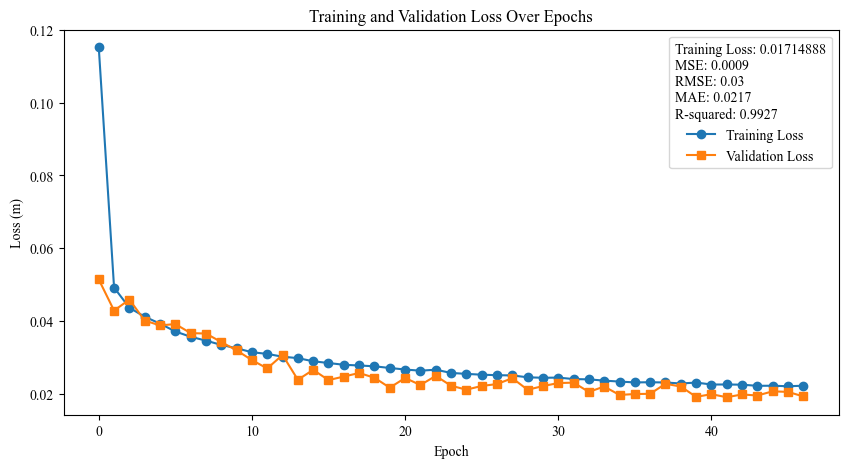

In [83]:
# Visualize the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (m)')
plt.title('Training and Validation Loss Over Epochs')
# Add the evaluation metrics to the legend
metrics_text = f'Training Loss: {test_loss[0]:.8f}\nMSE: {mse:.4f}\nRMSE: {rmse:.2f}\nMAE: {mae:.4f}\nR-squared: {r2:.4f}'
plt.legend(title=metrics_text)

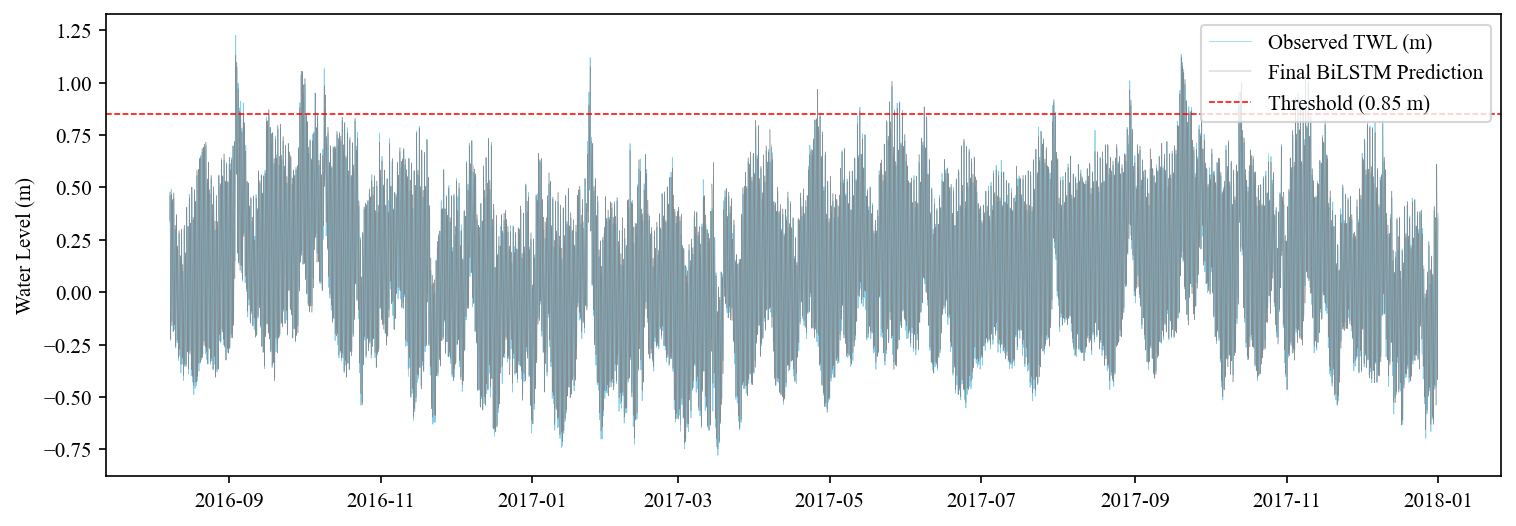

In [84]:
TWL_df = pd.DataFrame({
    'DateTime (GMT)': data_true['DateTime (GMT)'][train_size + lookback:],
    'Observed TWL (m)': y_original[train_size + lookback:].flatten()
})


TWL_df['BiLSTM_Prediction'] = test_predictions_original
TWL_df['DateTime (GMT)'] = pd.to_datetime(TWL_df['DateTime (GMT)'], format='%m/%d/%Y %H:%M')




threshold = 0.85

# Visualize the actual water levels and the predictions
plt.figure(figsize=(12, 4), dpi=150)
plt.plot(TWL_df['DateTime (GMT)'],TWL_df['Observed TWL (m)'], linewidth=0.35, marker='', label='Observed TWL (m)', color='skyblue')
plt.plot(TWL_df['DateTime (GMT)'],TWL_df['BiLSTM_Prediction'], linewidth=0.20, marker='', label='Final BiLSTM Prediction', color='grey')

plt.ylabel('Water Level (m)')
plt.axhline(y=threshold, color='r', linestyle='--', linewidth=0.75 , label="Threshold (0.85 m)")
plt.legend(loc='upper right')
#plt.savefig("64MAE1.png", bbox_inches='tight', dpi=300)
plt.show()


In [85]:
### The prior model is proof that the LSTM system is able to capture the trend in long term prediction.
### infact in the timeseries there are extremely high points where the BiLSTM model has done a decent job.
### In order to isolate its performance under extreme condition, what we will be isolating incident where, the water level reached critical state.
### In this case, a threshold of 0.8 (this is to be confrimed if this is a danger level) can be taken as a threshold proxy to measure the performace
### of the model under extreme conditions.
### we can plot the timelines to see how it performs also.



### incoder to isolate the conditions where the original dataset has water level above the threshold
### a thresholded_df has been isolated, with datetime.

TWL_df=pd.DataFrame({'DateTime (GMT)': data_true['DateTime (GMT)'][train_size+lookback:],
                          'Observed TWL (m)': y_original[train_size+lookback:].flatten(), 'BiLSTM Predicted':test_predictions_original[:].flatten()})
# Convert 'DateTime (GMT)' to datetime (timestamps)
TWL_df['DateTime (GMT)'] = pd.to_datetime(TWL_df['DateTime (GMT)'], format='%m/%d/%Y %H:%M')

threshold_df= TWL_df[TWL_df['Observed TWL (m)'] >= threshold]


#calculate the metrics 
mse = mean_squared_error(threshold_df['Observed TWL (m)'], threshold_df['BiLSTM Predicted'])
mae = mean_absolute_error(threshold_df['Observed TWL (m)'], threshold_df['BiLSTM Predicted'])
rmse = math.sqrt(mean_squared_error(threshold_df['Observed TWL (m)'], threshold_df['BiLSTM Predicted']))
r2 = r2_score(threshold_df['Observed TWL (m)'], threshold_df['BiLSTM Predicted'])

print(f'Mean Squared Error (m) [Thresholded]: {mse:.4f}')
print(f'RMSE (m)[Thresholded]: {rmse:.2f}')
print(f'Mean Absolute Error (m) [Thresholded]: {mae:.4f}')
print(f'R-squared [Thresholded]: {r2:.4f}')
print('------------------------------------------------')
#######################################################

correlation_coeff, _ = pearsonr(threshold_df['Observed TWL (m)'], threshold_df['BiLSTM Predicted'])
print("Correlation Coefficient:", correlation_coeff)


Mean Squared Error (m) [Thresholded]: 0.0016
RMSE (m)[Thresholded]: 0.04
Mean Absolute Error (m) [Thresholded]: 0.0291
R-squared [Thresholded]: 0.7456
------------------------------------------------
Correlation Coefficient: 0.8963956462859829


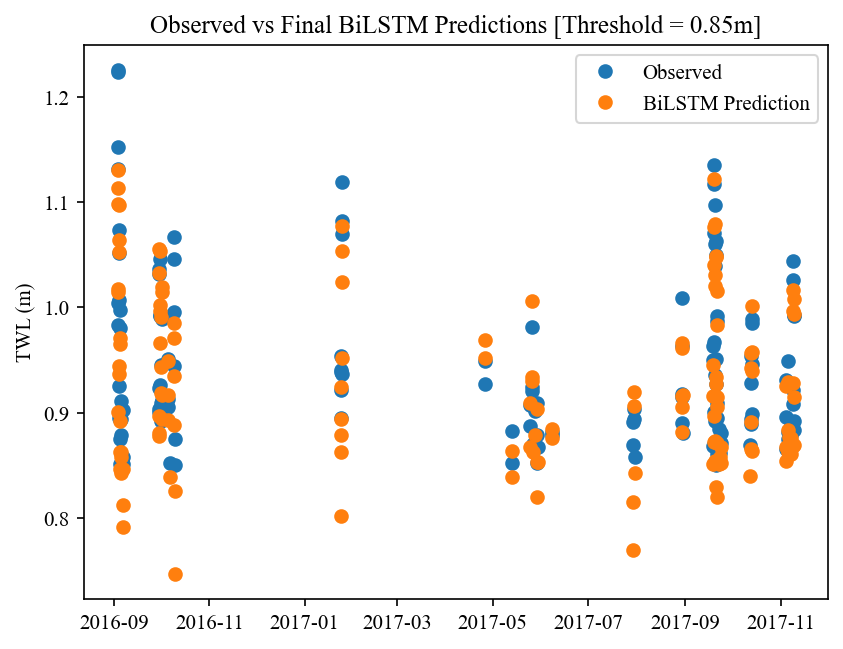

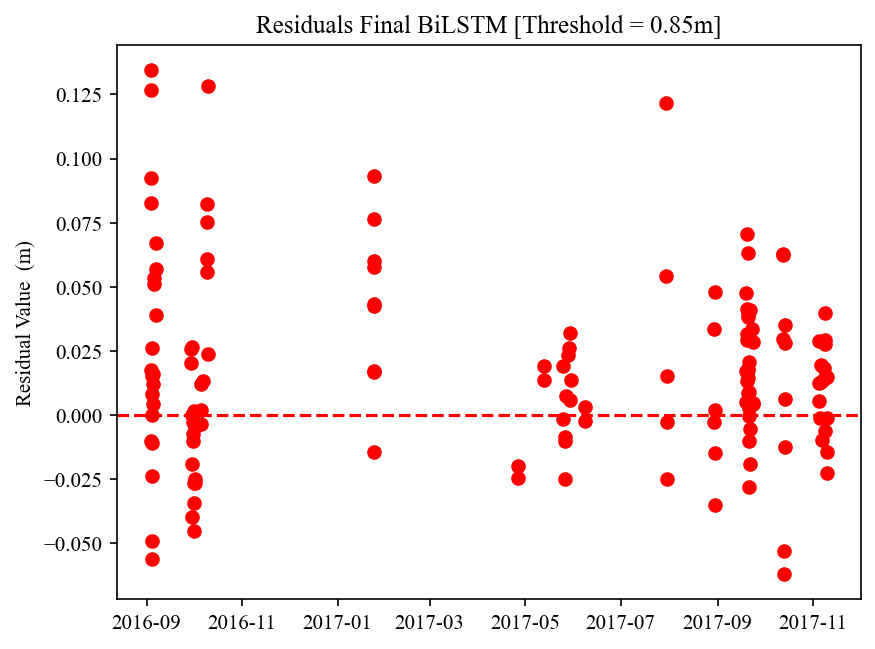

In [86]:
# Visual inspection
plt.figure(dpi=150)
plt.plot(threshold_df['DateTime (GMT)'],threshold_df['Observed TWL (m)'], marker='o', linestyle='', label="Observed")
plt.plot(threshold_df['DateTime (GMT)'], threshold_df['BiLSTM Predicted'], marker='o', linestyle='', label='BiLSTM Prediction')
plt.title(f"Observed vs Final BiLSTM Predictions [Threshold = 0.85m]")
plt.ylabel("TWL (m)")
plt.legend()
plt.show()

# Residual analysis
plt.figure(dpi=150)
residuals = threshold_df['Observed TWL (m)']-threshold_df['BiLSTM Predicted']
plt.plot(threshold_df['DateTime (GMT)'], residuals, marker='o', linestyle='', color='r')
plt.axhline(y=0, color='r', linestyle='--')
plt.title(f"Residuals Final BiLSTM [Threshold = 0.85m]")
plt.ylabel("Residual Value  (m)")
plt.savefig("BiLSTM128b3hMAE3.png", bbox_inches='tight', dpi=300)
plt.show()



In [87]:
### based on the continuity of the timeseries, there can be several plots.
### where the threshold is over 0.8 and there are consequtive data with differnce less than 5 days are taken as individual event.
### after screening out, any event where the len of the event is less than 12hours we are going to discard it those rows.

# Make a copy of the threshold_df
threshold_df = threshold_df.copy()

# Set the time delta value (7 days for event separation)
time_delta = 7
del_event = 12 # any event under 12 hours are deleted

# Convert 'DateTime (GMT)' to datetime in threshold_df
threshold_df.loc[:, 'DateTime (GMT)'] = pd.to_datetime(threshold_df['DateTime (GMT)'], format='%m/%d/%Y %H:%M')

# Calculate time differences between consecutive rows
threshold_df.loc[:, 'Time Diff'] = threshold_df['DateTime (GMT)'].diff()

# Separate events based on time difference greater than 7 days
threshold_df.loc[:, 'Unique Event > Threshold'] = threshold_df['Time Diff'] > pd.Timedelta(days=time_delta)

# Create an event ID to track different events
threshold_df.loc[:, 'Event ID'] = threshold_df['Unique Event > Threshold'].cumsum()

# Calculate the duration of each event
event_durations = threshold_df.groupby('Event ID').agg({
    'DateTime (GMT)': ['first', 'last']
})

# Compute the duration of each event in hours
event_durations['Duration (hours)'] = (event_durations['DateTime (GMT)', 'last'] - event_durations['DateTime (GMT)', 'first']).dt.total_seconds() / 3600

# Filter events that last for at least 12 hours
valid_events = event_durations[event_durations['Duration (hours)'] >= del_event].index

# Filter the original DataFrame to retain only valid events
threshold_df = threshold_df[threshold_df['Event ID'].isin(valid_events)]

# Check how many events are left after filtering
events_count = threshold_df['Event ID'].nunique()

print(f"Number of valid events after filtering: {events_count}")

# Display the filtered DataFrame
threshold_df




Number of valid events after filtering: 9


,DateTime (GMT),Observed TWL (m),BiLSTM Predicted,Time Diff,Unique Event > Threshold,Event ID
49741,2016-09-03 13:00:00,1.004,1.014361,NaT,False,0
49742,2016-09-03 14:00:00,1.131,1.113428,0 days 01:00:00,False,0
49743,2016-09-03 15:00:00,1.223,1.130499,0 days 01:00:00,False,0
49744,2016-09-03 16:00:00,1.225,1.098186,0 days 01:00:00,False,0
49745,2016-09-03 17:00:00,1.152,1.017521,0 days 01:00:00,False,0
...,...,...,...,...,...,...
60090,2017-11-08 18:00:00,0.922,0.928571,0 days 01:00:00,False,11
60112,2017-11-09 16:00:00,0.884,0.869264,0 days 22:00:00,False,11
60113,2017-11-09 17:00:00,0.992,0.993359,0 days 01:00:00,False,11
60114,2017-11-09 18:00:00,0.993,1.007731,0 days 01:00:00,False,11


In [88]:
# Get the starting and ending index for each event
event_indices = threshold_df.groupby('Event ID').agg({'DateTime (GMT)': ['first', 'last']}).reset_index()

# Merge with the original indices
event_indices['Start Index'] = threshold_df.groupby('Event ID').head(1).index
event_indices['End Index'] = threshold_df.groupby('Event ID').tail(1).index

# Renaming columns for clarity
event_indices.columns = ['Event ID', 'Start DateTime', 'End DateTime', 'Start Index', 'End Index']


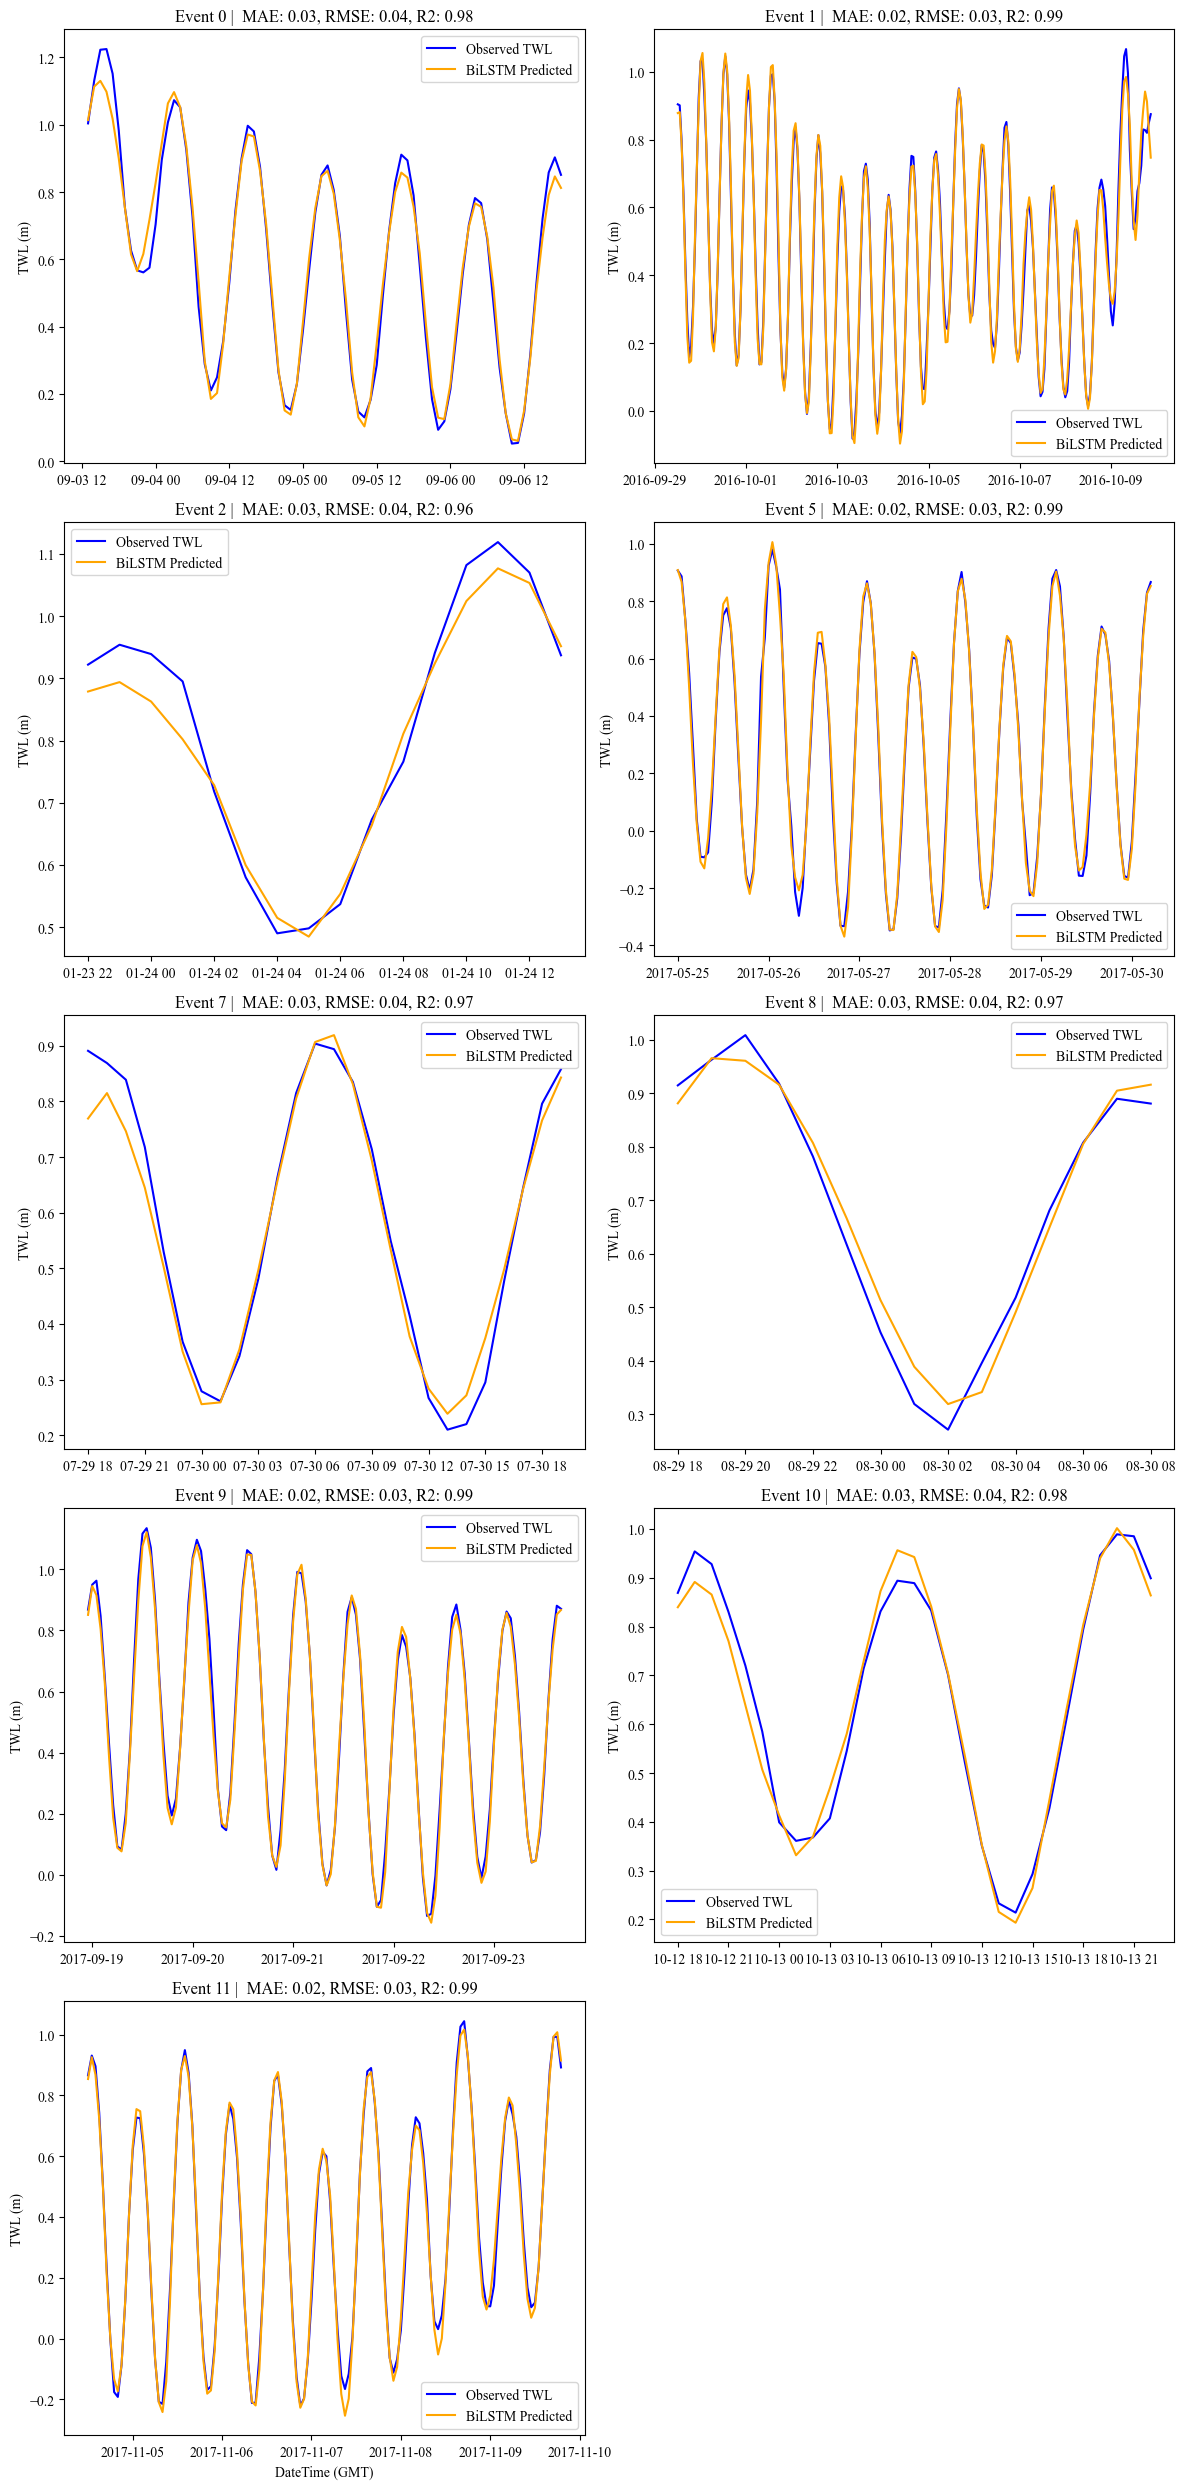

In [89]:
# Create subplots for each event based on the start and end indices
# Create subplots for each event based on the start and end indices
n_events = len(event_indices)
n_cols = 2
n_rows = (n_events + 1) // n_cols  # Round up to ensure space for all events

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows), sharex=False)
axes = axes.flatten()  # Flatten the axes array for easier indexing

for i, row in event_indices.iterrows():
    # Extract data for the current event using start and end indices
    start_idx = row['Start Index']
    end_idx = row['End Index']
    event_data = TWL_df.loc[start_idx:end_idx]

    # Calculate performance metrics
    performance_metrics = calculate_performance(event_data['Observed TWL (m)'], event_data['BiLSTM Predicted'])

    # Plot Observed and BiLSTM predicted TWL without markers
    axes[i].plot(event_data['DateTime (GMT)'], event_data['Observed TWL (m)'], label='Observed TWL', color='blue', linestyle='-', marker='')
    axes[i].plot(event_data['DateTime (GMT)'], event_data['BiLSTM Predicted'], label='BiLSTM Predicted', color='orange', linestyle='-', marker='')
    
    # Add titles and labels
    title = (f"Event {row['Event ID']} |  "
         f"MAE: {performance_metrics['MAE']:.2f}, "
         f"RMSE: {performance_metrics['RMSE']:.2f}, "
         f"R2: {performance_metrics['R2']:.2f}")

    axes[i].set_title(title)
    axes[i].set_ylabel('TWL (m)')
    axes[i].legend()

# Hide any unused subplots if the number of events is odd
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Set the x-label for the last subplot
axes[-2].set_xlabel('DateTime (GMT)')

# Adjust the layout for better visibility
plt.tight_layout()
plt.show()

In [91]:
%matplotlib ipympl